In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved waveforms

In [4]:
trainset = ws.HDF5WaveformSet('../data/dh_training_set.hdf5')
testset_rand = ws.HDF5WaveformSet('../data/dh_test_set_rand.hdf5')
testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform.hdf5')

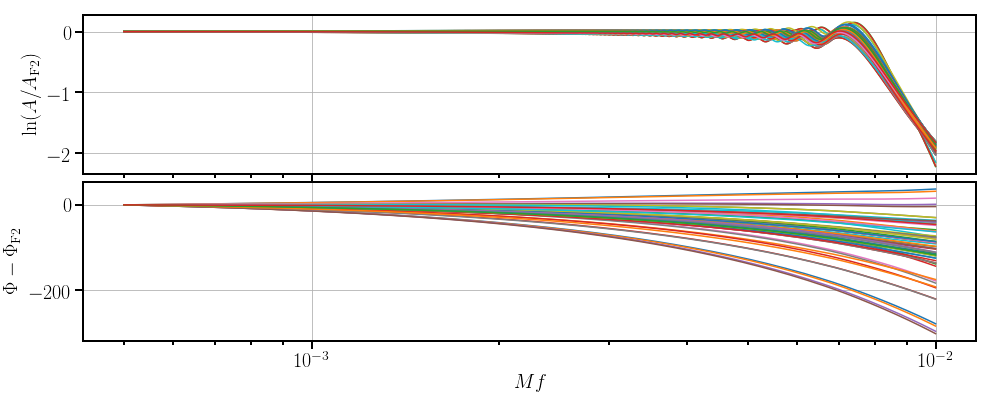

In [5]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

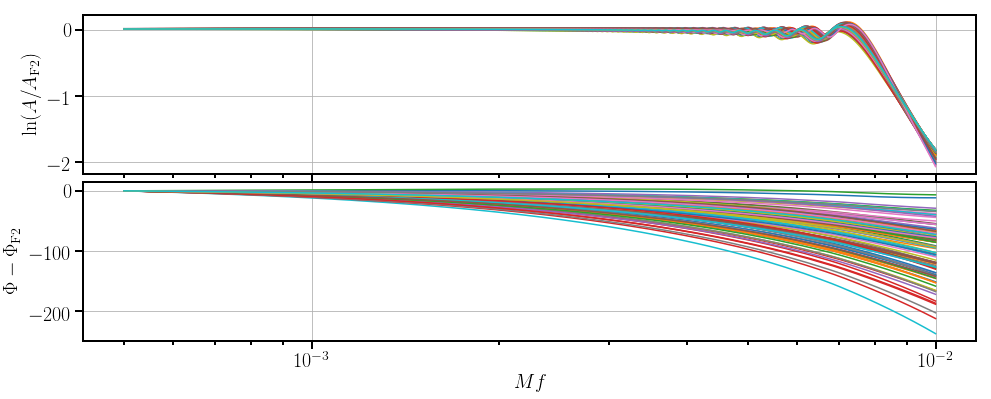

In [6]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([testset_rand[i] for i in range(0, len(testset_rand), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

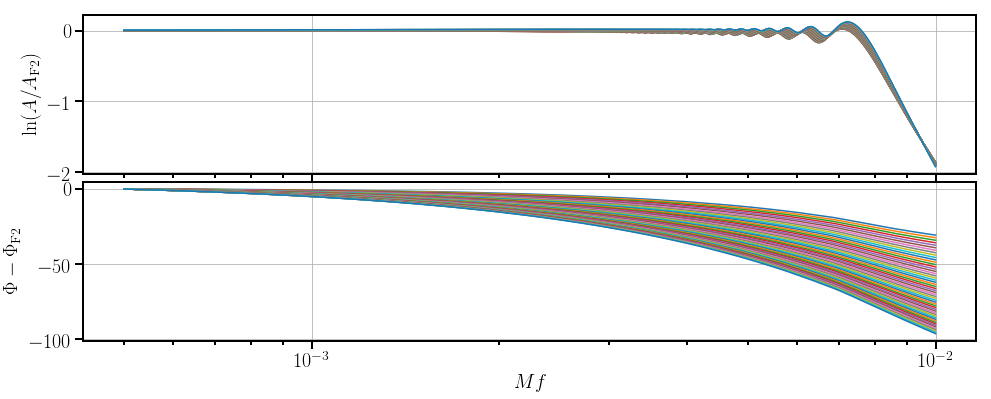

In [7]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([testset_uni[i] for i in range(0, len(testset_uni), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate reduced Bases for amplitude and phase

In [8]:
epsilon = 1.0e-6

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0452124259067
0.00694355041927
0.00508374945405
0.00122096764811
0.00099535463255
0.000575230835708
0.000196477439626
0.000158869020608
0.000112626639311
8.96863108411e-05
7.58608815513e-05
4.03497051277e-05
3.10371724545e-05
2.2552424264e-05
2.07253166239e-05
7.62419238165e-06
6.82174811006e-06
6.2023542986e-06
2.88910065938e-06
2.26847869578e-06
1.71725314424e-06
1.35189188344e-06
9.54587201951e-07


In [9]:
len(rbamprun.rb)

24

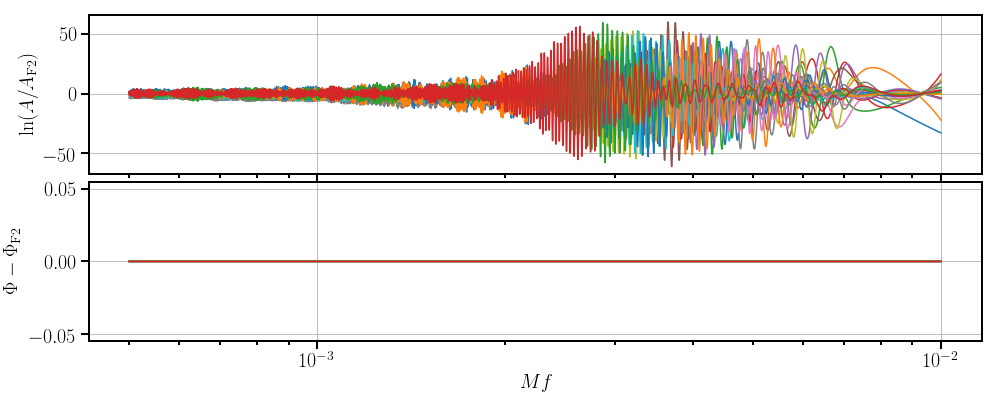

In [10]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbamprun.rb)
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

In [11]:
epsilon = 1.0e-10

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.917494428041
0.00352125467557
9.2606872669e-05
9.7876038464e-06
1.36178926158e-06
9.02266373948e-07
2.65723409609e-07
1.19437050361e-07
9.66612783149e-08
8.55543332845e-08
2.97759470413e-08
2.96606521566e-08
2.41588379302e-08
1.9497426007e-08
5.44770750732e-09
3.93620636086e-09
2.68139965787e-09
1.95873850473e-09
1.36120026362e-09
5.79968406633e-10
4.30009916563e-10
3.35527938766e-10
1.30627175743e-10
1.19561027745e-10
7.99944555041e-11


In [12]:
len(rbphaserun.rb)

26

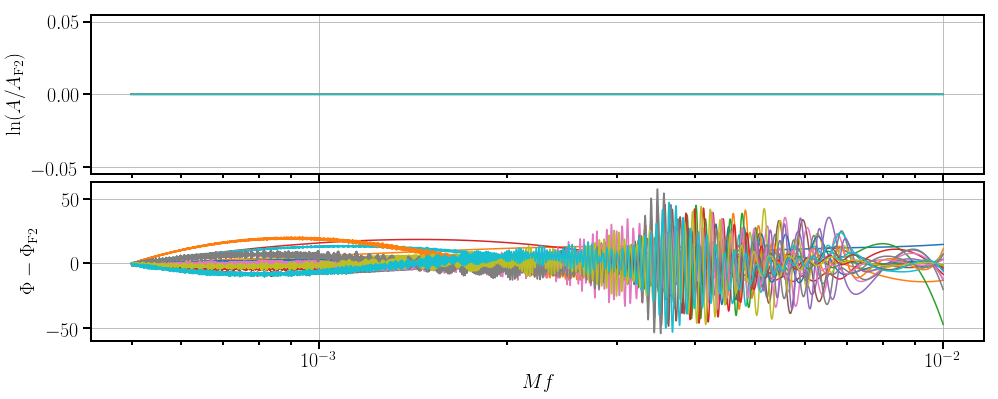

In [13]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbphaserun.rb[:20])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Empirical interpolating functions

You could restrict the allowed empirical nodes to be below a certain frequency or data sample
by altering imax = np.argmax(np.abs(residual)) in the function generate_new_empirical_node to 
only allow points below some value f_max.

In [14]:
def save_empirical_interpolating_function_list(filename, b_j, mf_node):
    """Save the empirical interpolating functions as a HDF5WaveformSet object.
    """
    bset = ws.HDF5WaveformSet(filename)
    
    for j in range(len(b_j)):
        # b_j don't have waveform parameters associated with them,
        # but you do want to save the node frequency node_mf 
        parameters = np.array([mf_node[j]])
        bset.set_waveform(j, b_j[j], parameters)
    
    bset.close()

In [15]:
# Use the first 20 bases
namp = 20
nphase = 20
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbamprun.rb[:namp], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbphaserun.rb[:nphase], 'phase')

In [16]:
# Get the frequencies Mf at each empirical node, and sort B's by the node frequency.

# amp
mf_amp = Bamp_j[0].x[empirical_node_indices_amp]
mf_Bamp_list = [[mf_amp[i], Bamp_j[i]] for i in range(len(mf_amp))]
mf_Bamp_list_sorted = sorted(mf_Bamp_list, key=lambda x: x[0])

# phase
mf_phase = Bphase_j[0].x[empirical_node_indices_phase]
mf_Bphase_list = [[mf_phase[i], Bphase_j[i]] for i in range(len(mf_phase))]
mf_Bphase_list_sorted = sorted(mf_Bphase_list, key=lambda x: x[0])

In [17]:
filename = '../data/Bamp.hdf5'
mf = [mf_Bamp_list_sorted[i][0] for i in range(len(mf_Bamp_list_sorted))]
B_j = [mf_Bamp_list_sorted[i][1] for i in range(len(mf_Bamp_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

filename = '../data/Bphase.hdf5'
mf = [mf_Bphase_list_sorted[i][0] for i in range(len(mf_Bphase_list_sorted))]
B_j = [mf_Bphase_list_sorted[i][1] for i in range(len(mf_Bphase_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

In [18]:
# Now load them
Bamp_j = ws.HDF5WaveformSet('../data/Bamp.hdf5')
Bphase_j = ws.HDF5WaveformSet('../data/Bphase.hdf5')

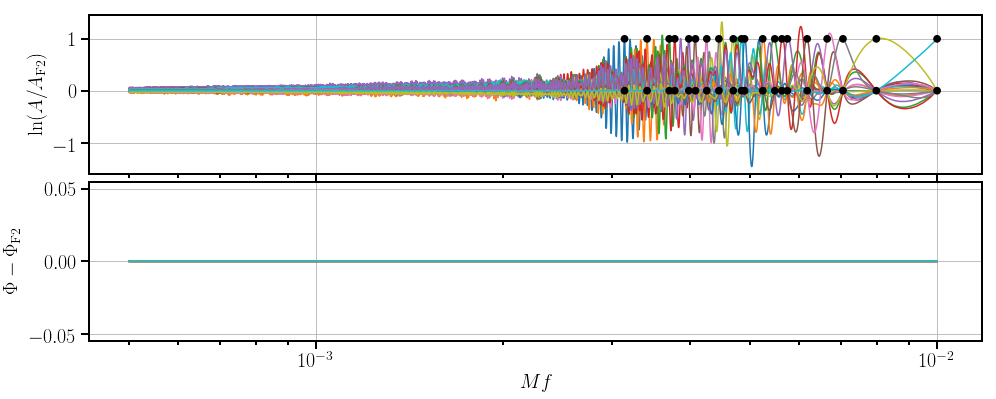

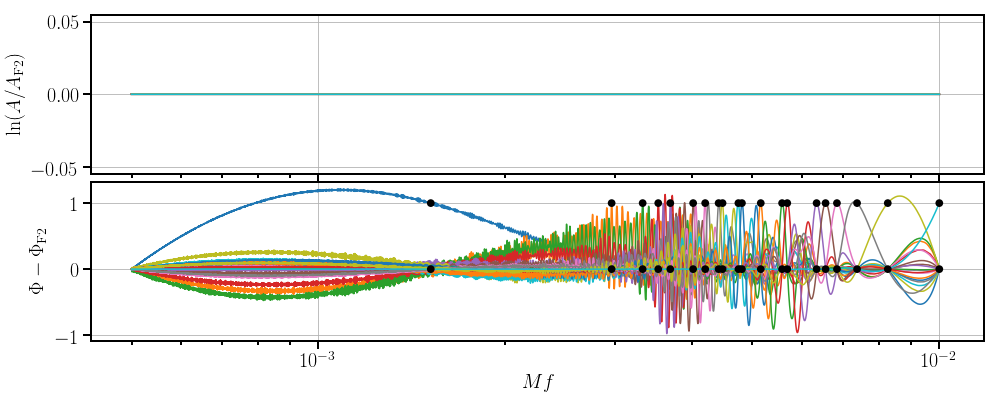

In [19]:
hs = [Bamp_j[j] for j in range(len(Bamp_j))]
mfs = np.array([Bamp_j.get_waveform(j, data='parameters')[0] for j in range(len(Bamp_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax1.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax1.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

hs = [Bphase_j[j] for j in range(len(Bphase_j))]
mfs = np.array([Bphase_j.get_waveform(j, data='parameters')[0] for j in range(len(Bphase_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax2.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax2.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [20]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(Bamp_j)):
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(Bphase_j)):
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [21]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print damp_gp.kernel_
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[[  4.53243086e-03   1.81297234e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  4.53243086e-07   4.53243086e-03]]
[  3.96616118e-02   1.61280949e+00   3.48626193e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.48255442e-03]
1
[[  5.75118875e-03   2.30047550e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  5.75118875e-07   5.75118875e-03]]
[  3.65625220e-02   1.63166355e+00   2.80488864e+00   3.58256595e+00
   4.00000000e+04   4.00000000e+04   1.63728364e-03]
2
[[  5.89068887e-03   2.35627555e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  5.89

In [22]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, sigma_n_factor=[1.0e-6, 0.1])
#     hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, 
#                                                              sigma_f_factor=[0.1, 10.0], 
#                                                              sigma_n_factor=[1.0e-5, 0.1], 
#                                                              length_scale_factor=[0.1, 10.0])
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print dphase_gp.kernel_
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[[  2.98707006e+00   1.19482802e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  2.98707006e-05   2.98707006e+00]]
[  1.63244925e+01   1.05319776e+00   3.13807926e+00   5.60000000e+00
   3.47114016e+04   4.00000000e+04   3.29700183e-05]
1
[[  7.42402127e+00   2.96960851e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  7.42402127e-05   7.42402127e+00]]
[  3.62329134e+01   1.01102012e+00   3.44466408e+00   5.60000000e+00
   3.19209102e+04   4.00000000e+04   8.54165090e-05]
2
[[  8.54672602e+00   3.41869041e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  8.54

In [23]:
filename = '../data/amp_gp.hdf5'
gp_list = damp_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

filename = '../data/phase_gp.hdf5'
gp_list = dphase_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

# Diagnosing GP fit

In [24]:
def symlog_yticks(axes):
    decade = np.array([0.1*i for i in range(10)])
    ticks = []
    for i in range(-1, 2):
        ticks.append(decade*10**i)
    ticks = np.concatenate(np.array(ticks))
    ticks_rev = np.flip(ticks, 0)
    all_ticks = np.concatenate((-ticks_rev, ticks)) 
    axes.set_yticks(all_ticks, minor=True)
    #axes.set_yticks(all_ticks)

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


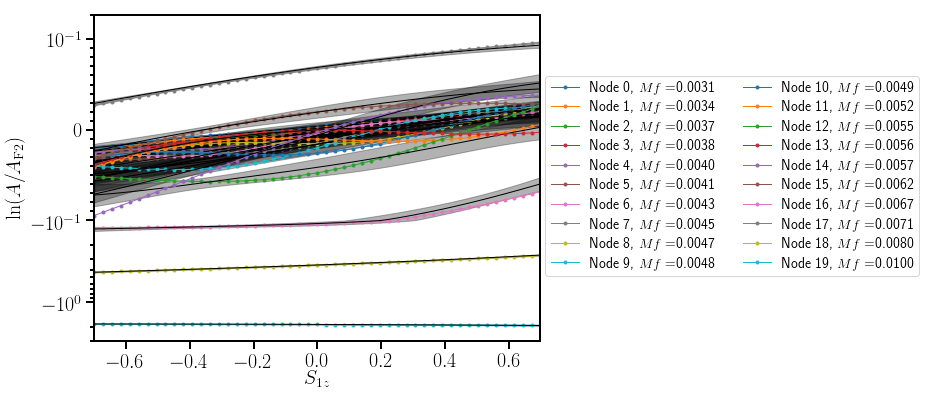

In [25]:
params_test = testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(damp_gp_list)):
    # Node frequency
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    damp_test = np.array([testset_uni[i].interpolate('amp')(mf) for i in range(len(testset_uni))])
    damp_gp = damp_gp_list[j]
    damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], damp_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.4f}'.format(j, mf))
    axes.plot(params_test[:, 1], damp_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_yscale('symlog', linthreshy=0.1)
#axes.set_yticks(ticks, minor=True)
symlog_yticks(axes)
axes.set_ylim(-3, 0.2)
axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\ln(A/A_{\rm F2})$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


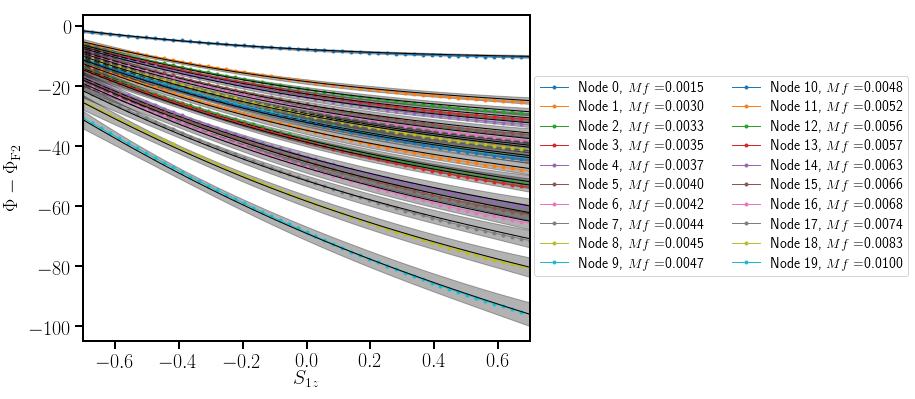

In [26]:
params_test = testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(dphase_gp_list)):
    # Node frequency
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    dphase_test = np.array([testset_uni[i].interpolate('phase')(mf) for i in range(len(testset_uni))])
    dphase_gp = dphase_gp_list[j]
    dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], dphase_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.4f}'.format(j, mf))
    axes.plot(params_test[:, 1], dphase_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

# Diagnostics (Everything below should go in separate notebooks)

In [148]:
def fractional_amp_error(dlnamp_sur, dlnamp_true):
    """Calculate A_sur/A_true-1 given dlnA_sur and dlnA_true,
    where dlnA_sur = lnA_sur-lnA_ref and dlnA_true = lnA_true-lnA_ref.
    """
    error = np.exp(dlnamp_sur-dlnamp_true)-1.0
    return np.max(np.abs(error))

def phase_error(dphase_sur, dphase_true):
    """Calculate Phi_sur-Phi_true given dPhi_sur and dPhi_true,
    where dPhi_sur = Phi_sur-Phi_ref and Phi_true = Phi_true-Phi_ref.
    """
    error = dphase_sur-dphase_true
    return np.max(np.abs(error))

In [149]:
params_rand = []
amp_err = []
phase_err = []
for i in range(len(testset_rand)):
    hrand = testset_rand[i]
    params = testset_rand.get_waveform(i, data='parameters')
    hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)
    
    mfhigh = 0.020
    dlnamp_sur = hsur.amp[hsur.x<=mfhigh]
    dlnamp_true = hrand.amp[hrand.x<=mfhigh]
    dphase_sur = hsur.phase[hsur.x<=mfhigh]
    dphase_true = hrand.phase[hrand.x<=mfhigh]
    
    ae = fractional_amp_error(dlnamp_sur, dlnamp_true)
    pe = phase_error(dphase_sur, dphase_true)
    
    params_rand.append(params)
    amp_err.append(ae)
    phase_err.append(pe)

In [150]:
np.max(amp_err), np.max(phase_err)

(0.027987663792280015, 1.3002808795054115)

In [151]:
i_ampmax = np.array(amp_err).argmax()
i_phasemax = np.array(phase_err).argmax()

In [152]:
params_rand[i_ampmax], params_rand[i_phasemax]

(array([  7.80645276e-01,  -5.53056983e-01,  -6.34848146e-01,
          7.74212883e+03,   9.64382217e+03]),
 array([  3.99588848e-01,  -6.34782032e-01,  -5.05633045e-01,
          6.71246151e+02,   6.99529339e+02]))

[  3.99588848e-01  -6.34782032e-01  -5.05633045e-01   6.71246151e+02
   6.99529339e+02]


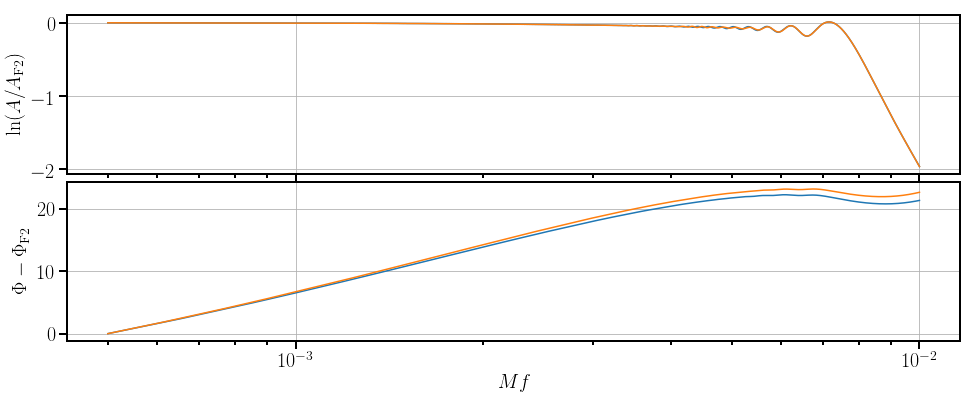

In [238]:
#i = i_ampmax
i = i_phasemax

hrand = testset_rand[i]
params = testset_rand.get_waveform(i, data='parameters')
print params
hsur = surrogate.reconstruct_amp_phase_difference(params, Bamp_j, Bphase_j, damp_gp_list, dphase_gp_list)

# Plot h_true and h_sur
fig, (ax1, ax2) = wave.plot_waveforms_fd([hrand, hsur])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

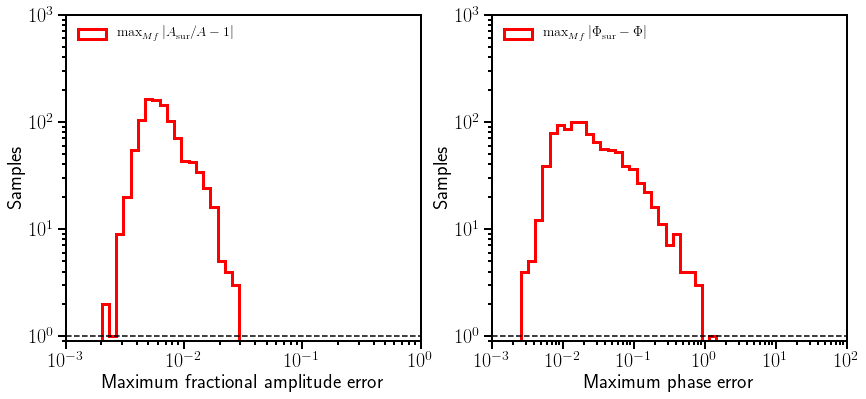

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.hist(amp_err, bins=np.logspace(-3, 0, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|A_{\rm sur}/A-1|$')
ax1.axhline(1.0, c='k', ls='--')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1.0e-3, 1.0])
ax1.set_ylim([0.9, 1000])
ax1.set_xlabel('Maximum fractional amplitude error')
ax1.set_ylabel('Samples')
ax1.legend(loc='upper left', frameon=False)

ax2.hist(phase_err, bins=np.logspace(-3, 2, 50), histtype='step', 
          ls='-', lw=3, color='red', alpha=1.0, label=r'$\max_{Mf}|\Phi_{\rm sur}-\Phi|$')
ax2.axhline(1.0, c='k', ls='--')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1.0e-3, 100.0])
ax2.set_ylim([0.9, 1000])
ax2.set_xlabel('Maximum phase error')
ax2.set_ylabel('Samples')
ax2.legend(loc='upper left', frameon=False)

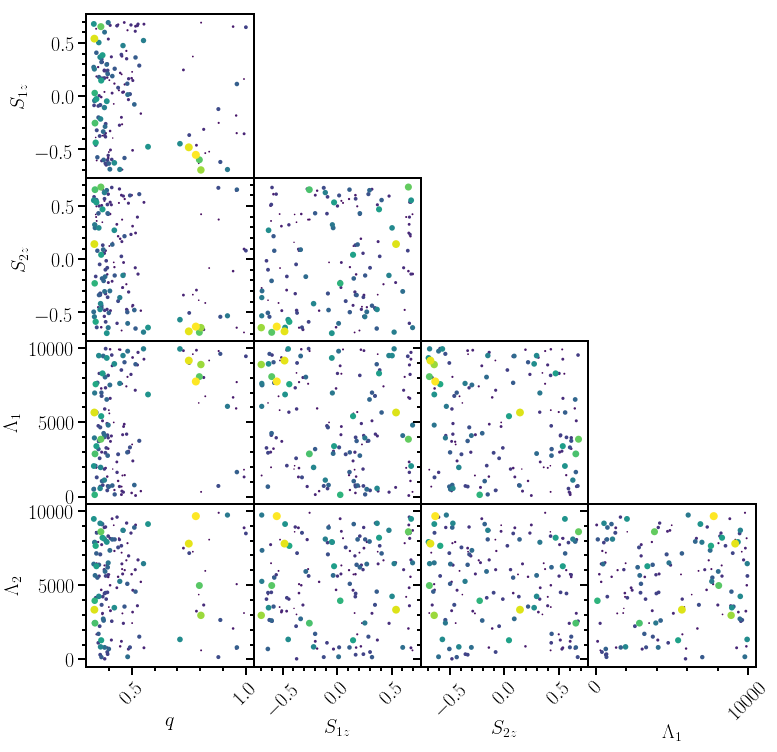

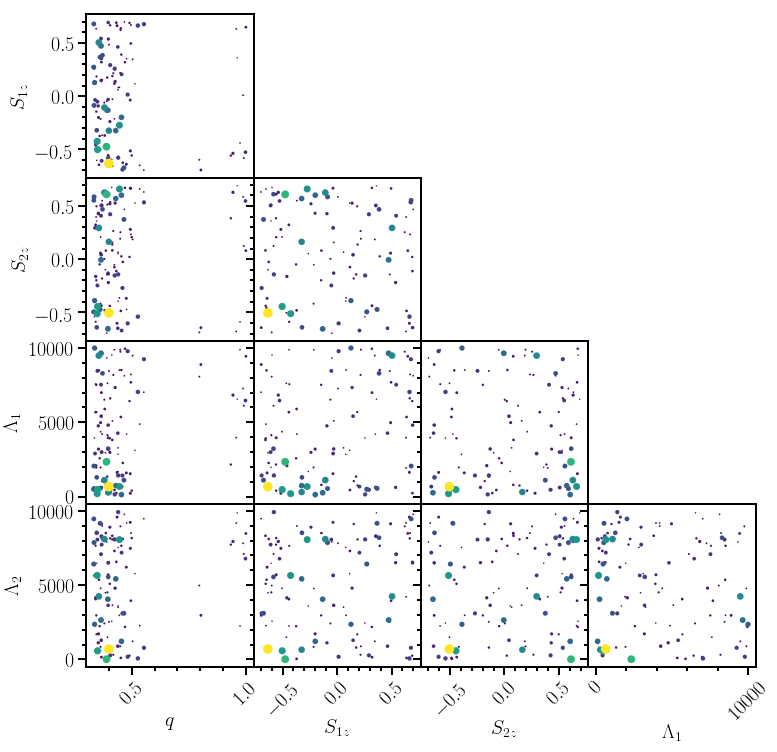

In [166]:
labels = [r'$q$', r'$S_{1z}$', r'$S_{2z}$', r'$\Lambda_1$', r'$\Lambda_2$']
params = params_rand

error = np.array(amp_err)
#print len(error[error>=0.1])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.01, figsize=(10, 10))

error = phase_err
#print len(error[error>=1.0])
fig, ax = diagnostics.error_2d_triangle_plot(params, error, labels, threshold=0.1, figsize=(10, 10))

# Plot frequency dependent error estimates

In [167]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'

Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

In [168]:
def error_of_frequency(point, B_j, gp_list, data='amp'):
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

In [177]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
f, eps = error_of_frequency(point, Bamp, damp_gp_list, data='amp')
#f, eps = error_of_frequency(point, Bphase, dphase_gp_list, data='phase')

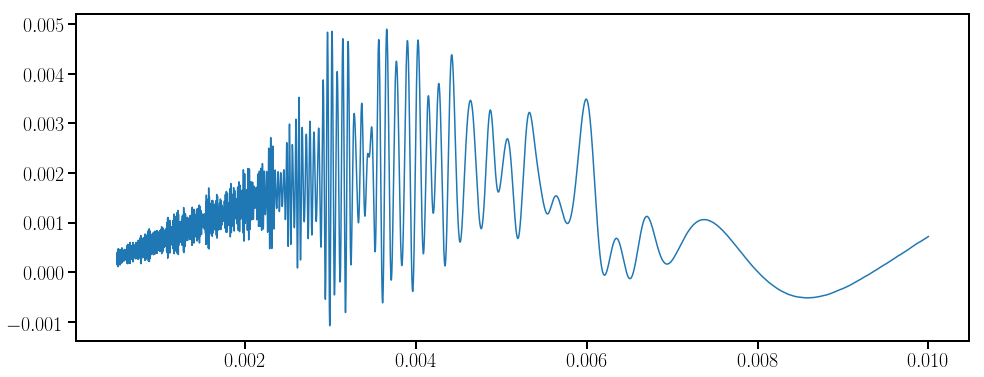

In [178]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.plot(f, eps)
#ax1.set_xscale('log')
#ax1.set_xlim(1.0e-4, 0.1)

# Plot GP functions

In [179]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')

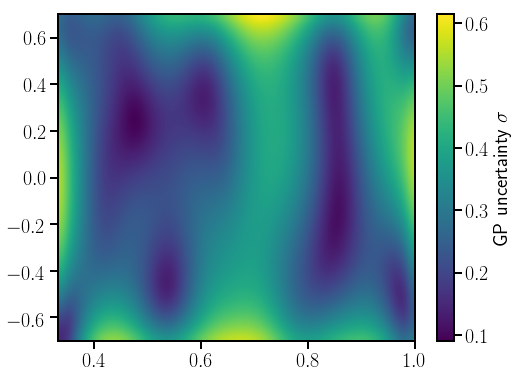

In [182]:
# print maximum_error(func, gp, limits, error_type='absolute', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional', nsample=100000)
# print maximum_error(func, gp, limits, error_type='fractional_full_range', nsample=100000)

#x2, x3, x4 = 0.4, 5000.0, 5000.0
x0, x1, x2, x3, x4 = params_rand[i_phasemax]
def gp_predict_error(x0, x1):
    i = 19
    return dphase_gp_list[i].predict(np.array([[x0, x1, x2, x3, x4]]), return_std=True)[1][0]

fig, (ax1) = plt.subplots(1, 1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
#plot_numbered_points(ax1, points)

0.00304761357728


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


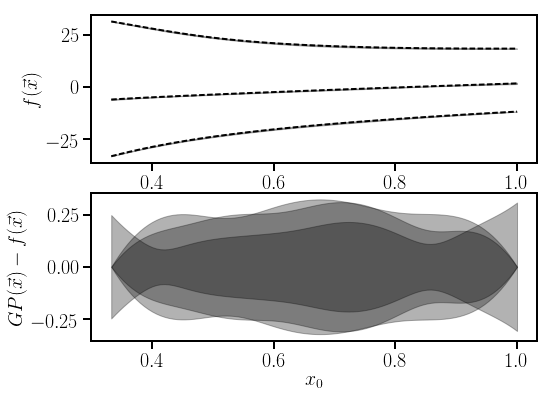

In [184]:
#x2, x3, x4 = 0.0, 2000.0, 2000.0
#x0, x1, x2, x3, x4 = params_rand[i_phasemax]
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase_j.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))